# Kalman Filters

Kalman filters are one of the predominant tracking algorithms. They are used across multiple fields, from things like measuring rocket temperature to tracking objects in self driving cars. The following is my basic tutorial on how to implement a Kalman filter. I will first show how to track an object with one measurement, and then incorporate multiple measurements for better accuracy.

## Motion Model

For the simulation our first step will be to simulate the true locations of our object. 

1. The object is described by the state vector, X = [x, y,x',y'], where x,y is location of an object in the x,y axis and x', y' is the velocity in the respective axis. We initialize it to [0,0,3,3]. 
2. We will use a constant velocity model (i.e. acceleration = 0). Then the update equation will by x(t+1) = x(t)+x'(t)*(t-(t-1)), x'(t+1) = x'(t), y(t+1) = y(t) + y'(t)*(t-(t-1)) and y'(t+1) = y(t).

We will use a more complicated motion model but lets first get this to work.

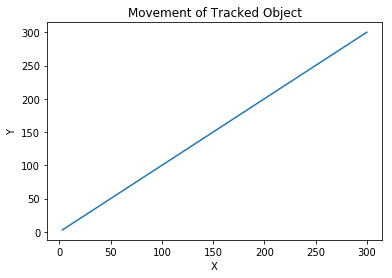

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

#initialize the location of the car
X = np.array([0,0,3,3]).T

#initialize the motion model
dt = 1 #dt is the time step
A = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])

#store the true motion of the object
x_true = []
y_true = []
for i in range(100):
    X= np.dot(A,X)
    x_true.append(X[0])
    y_true.append(X[1])

plt.plot(x_true,y_true)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Movement of Tracked Object')
plt.show()

### Incorporation noise in motion model

We modeled a system moving at constant speed of (3,3). However any system will have some imperfections. For e.g. if we are trying to track a car that is programmed to move with constant velocity of 3, 3. The actual movement will be slightly off, due to imperfections in the car design and variations in the external world that we didn't account for in the model (variation in friction, fluctuation in fuel consumption, etc.). We can model these fluctuation by adding noise (X_noise) to our system.

$$
{(X_{t+1})}_{4 \times 1} = {(A)}_{4 \times 4} + {(X_{noise})}_{4 \times 1}
$$

where $X$, is the state of the system,
$$
\mathbf{X} =  \begin{bmatrix}
p_x\\
p_y\\
v_x\\
v_y
\end{bmatrix}
$$

where,<br> 
$p_x$ is position in x-direction,<br>
$p_y$ is position in x-direction,<br>
$v_x$ is velocity in x-direction, and<br>
$v_y$ is velocity in x-direction

and $A$ is the state gain, which we take as,
$$
\mathbf{A} =  \begin{bmatrix}
1 & 0 & dt & 0\\
1 & 0 & 0 & dt\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}
$$

where $dt$ is the time step which we take as 1.


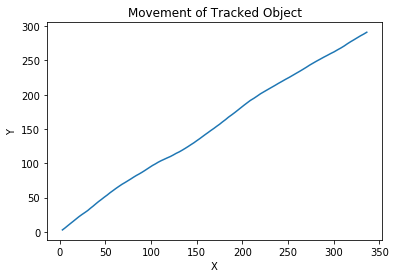

In [37]:
mu = 0
sigma = .1

#initialize the location of the car
X = np.array([0,0,3,3]).T

#initialize the motion model
dt = 1 #dt is the time step
A = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])

#store the true motion of the object
x_true = []
y_true = []
for i in range(100):
    X= np.dot(A,X)
    ############ NEW ###################
    X_noise = np.random.normal(mu, sigma, 4)
    X = X + X_noise
    ###################################
    x_true.append(X[0])
    y_true.append(X[1])

plt.plot(x_true,y_true)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Movement of Tracked Object')
plt.show()



## Measurement (and Measurement Noise)

Lets say we don't know the exact location of the car we are tracking in the previous step. Given we know the initial location of the car and the desired system behavior why can we not accurately tell where the car will be at time, t? The reason is the process noise that we added into our model in the last step. So at any time t, we can only know the exact location of the car by observing it at that time. To do this we usually use a sensor, for eg. a camera or a LiDar. The problem is, even these sensors have some noise.

Ideally the observed state,

$$
(Y)_{2 \times 1} = (C)_{2 \times 4} (X)_{4 \times 1}
$$
where,
$$
\mathbf{C} =  \begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}
$$

But again we have to add some noise,
$$
Y_{2 \times 1} = (C)_{2 \times 4}(X)_{4 \times 1} + ({Y_{noise}})_{2 \times 1}
$$

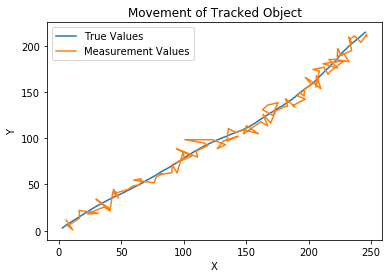

In [38]:
mu = 0
sigma_process = .1
sigma_measure = 5

#initialize the location of the car
X = np.array([0,0,3,3]).T

#initialize the motion model
dt = 1 #dt is the time step
A = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])

#Measurement Matrix
C = np.array([[1,0,0,0],[0,1,0,0]])

#store the true motion of the object
x_true = []
y_true = []
x_measure = []
y_measure = []
for i in range(100):
    #True values
    X= np.dot(A,X)
    X_noise = np.random.normal(mu, sigma_process, 4)
    X = X + X_noise
    x_true.append(X[0])
    y_true.append(X[1])
    
    ########### New ##############
    Y = np.matmul(C,X) + np.random.normal(mu, sigma_measure, 2)
    x_measure.append(Y[0])
    y_measure.append(Y[1])

plt.plot(x_true,y_true)
plt.plot(x_measure,y_measure)
plt.legend(['True Values', 'Measurement Values', ], loc='upper left')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Movement of Tracked Object')
plt.show()

## Kalman Filters

The Kalman filter predicts the current location of the object based on the previous prediction and the current measurement. The idea is that if both inputs or noisy then by combining both of the gaussian noises, we will get a prediction with a lower variance.

### Prediction

The first part of the Kalman filter is to predict where our tracked object is located at based on previous knowledge about the system state. Prediction consists of two equations:

1. Assuming that the previous prediction was reasonably accurate, and if the we know how the system is supposed to behave (in our case move 3,3), then we can predict where the object tracked will be:

$$
(\dot{X_{t}})_{4 \times 1} = (A)_{4 \times 4}(\dot{X_{t-1}})_{4 \times 1}
$$

where,<br>
$\dot{X_{t}}$, is the predicted state at time t, and <br>
$\dot{X_{0}}$, is initialized to the initial state of the object (we took it as (0,0,3,3)).



2. P is the process covariance matrix. We take the non-diagonal elements and set it to zero because we assume zero relationship between two different measurements. If P is  large, it means that the Kalman filter is not that confident about its predicted state values (X_pred). (For P, we are basically scaling the previous covariance with the state transition matrix: $var(aX) = a^2 \times var(X)$

$$
(P_{t})_{4 \times 4} = (A)_{4 \times 4}(P_{t-1})_{4 \times 4}(A^{T})_{4 \times 4}
$$

In [39]:
def predict(A,X_pred,P):  
    X_pred = np.dot(A,X_pred)
    P = np.dot(np.dot(A,P),A.T)
    return X_pred,np.diag(np.diag(P))

### Update

The Kalman filter now takes into consideration the measured values by the sensor. It involves three steps:

#### 1. Find the Kalman gain:

The Kalman gain is basically a measure of which value are we more confident about: the predicted value or the observed measurement. A simplified version of looking at this function would be the ratio of the process noise by the sum of process noise and measurement noise.

$$
(K)_{4 \times 2} = \frac{(P)_{4 \times 4}(C^{T})_{4 \times 2}}{(C)_{2 \times 4}(P)_{4 \times 4}(C^{T})_{4 \times 2}+(R)_{2 \times 2}}
$$

#### 2. Find the updated prediction value based on K

As K tends to 1, prediction will be entirely dependent on measurement value. Conversely, as it tends to 0, the prediction will be entirely dependent on previous predicted value.


$$
\dot{(X_t)}_{4 \times 1} = \dot{(X_t)}_{4 \times 1} + (K)_{4 \times 2}((Y)_{2 \times 1}-(C)_{2 \times 4}\dot{(X_t)}_{4 \times 1})
$$

####  3. Covariance Matrix Update

Based on the changes of X_pred, the corresponding covariance will also be updated.

$$
(P_{t})_{4 \times 4} = \{(I)_{4 \times 4}-(K)_{4 \times 2}(C)_{2 \times 4}\}(P_{t})_{4 \times 4}
$$

If, K is the ratio of how important measurement, then $I-KC$ is the importance of predicted value.

In [40]:
def update(P,C,R,X_pred,Y):
    num = np.dot(P,C.T)
    den = np.dot(np.dot(C,P),C.T)+R
    K = np.matmul(num,inv(den))
    X_pred = X_pred + np.dot(K,(Y-np.dot(C,X_pred)))
    P = np.dot((np.eye(4)- np.dot(K,C)),P)
    return X_pred,P

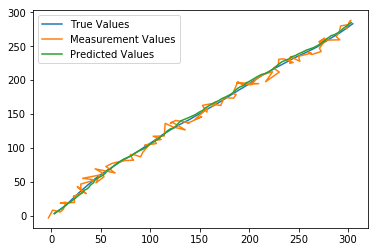

In [44]:
mu = 0
sigma_process = .1
sigma_measure = 5

#initialize the location of the car
X = np.array([0,0,3,3]).T

#initialize the motion model
dt = 1 #dt is the time step
A = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])

#Measurement Matrix
C = np.array([[1,0,0,0],[0,1,0,0]])

#store the true motion of the object
x_true = []
y_true = []
x_measure = []
y_measure = []
x_pred = []
y_pred = []


#Initialize the initial location and variance
X_pred = X
P = np.eye(4)*sigma_process
R = np.eye(2)*sigma_measure
for i in range(100):
    #True values
    X= np.dot(A,X)
    X_noise = np.random.normal(mu, sigma_process, 4)
    X = X + X_noise
    x_true.append(X[0])
    y_true.append(X[1])
    
    #Measured Values
    Y = np.dot(C,X) + np.random.normal(mu, sigma_measure, 2)
    x_measure.append(Y[0])
    y_measure.append(Y[1])
    
    #Kalman Filter
    X_pred,P = predict(A,X_pred,P)
    X_pred,P = update(P,C,R,X_pred,Y)
    x_pred.append(X_pred[0])
    y_pred.append(X_pred[1])
    

plt.plot(x_true,y_true)
plt.plot(x_measure,y_measure)
plt.plot(x_pred,y_pred)
plt.legend(['True Values', 'Measurement Values','Predicted Values'], loc='upper left')
plt.show()

### Trying to find out how to break the Kalman filter

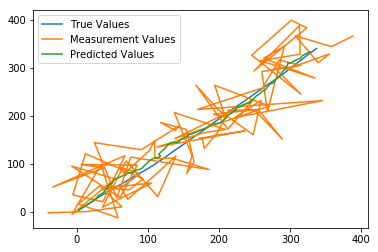

In [46]:
mu = 0
sigma_process = .1
sigma_measure = 40

#initialize the location of the car
X = np.array([0,0,3,3]).T

#initialize the motion model
dt = 1 #dt is the time step
A = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])

#Measurement Matrix
C = np.array([[1,0,0,0],[0,1,0,0]])

#store the true motion of the object
x_true = []
y_true = []
x_measure = []
y_measure = []
x_pred = []
y_pred = []


#Initialize the initial location and variance
X_pred = X
P = np.eye(4)*sigma_process
R = np.eye(2)*sigma_measure
for i in range(100):
    #True values
    X= np.dot(A,X)
    X_noise = np.random.normal(mu, sigma_process, 4)
    X = X + X_noise
    x_true.append(X[0])
    y_true.append(X[1])
    
    #Measured Values
    Y = np.dot(C,X) + np.random.normal(mu, sigma_measure, 2)
    x_measure.append(Y[0])
    y_measure.append(Y[1])
    
    #Kalman Filter
    X_pred,P = predict(A,X_pred,P)
    X_pred,P = update(P,C,R,X_pred,Y)
    x_pred.append(X_pred[0])
    y_pred.append(X_pred[1])
    

plt.plot(x_true,y_true)
plt.plot(x_measure,y_measure)
plt.plot(x_pred,y_pred)
plt.legend(['True Values', 'Measurement Values','Predicted Values'], loc='upper left')
plt.show()